# AVOCADO 가격 예측 (Facebook Prophet ) 



# STEP #0: 데이터셋

- 데이터는 미국의 아보카도 리테일 데이터 입니다. (2018년도 weekly 데이터)  
- 아보카도 거래량과 가격이 나와 있습니다. 

컬럼 설명 :

- Date - The date of the observation
- AveragePrice - the average price of a single avocado
- type - conventional or organic
- year - the year
- Region - the city or region of the observation
- Total Volume - Total number of avocados sold 
- 4046 - Total number of avocados with PLU 4046 sold - PLU는 농산물 코드입니다
- 4225 - Total number of avocados with PLU 4225 sold
- 4770 - Total number of avocados with PLU 4770 sold



# STEP #1: 데이터 준비

### Prophet 라이브러리
**참고로 fbprophet은 구글 colab에는 깔려있음
- install : 
     pip install fbprophet
     
- 위 에러 발생시 : 
    conda install -c conda-forge fbprophet
 

- 레퍼런스 : https://research.fb.com/prophet-forecasting-at-scale/
https://facebook.github.io/prophet/docs/quick_start.html#python-api


** 가상환경을 만들어 놓고 
여기에서 사용한 개발 환경, 라이브러리등을 그대로 적용해서
사용할 수 있음

왜냐하면 라이브러리 유무랑 버전 호환등으로 colab에서는 잘 되도 다른데에서는 호환성, 버전 문제가 생길 수 있기 때문임

In [1]:
# import libraries 
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import random
import seaborn as sns
from fbprophet import Prophet


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

In [4]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/data-vision/day18')

In [6]:
# avocado.csv 데이터 읽기
avocado_df =  pd.read_csv('avocado.csv')


# STEP #2: EDA(Exploratory Data Analysis) :  탐색적 데이터 분석
- head()로 보기
- 차트 보기
- 컬럼간의 데이터 확인

용어 중요!

In [7]:
avocado_df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


### 필요없는 맨 처음 컬럼을 제거하시오

In [ ]:
# 불필요한 컬럼 제거
# 방법은 drop/ 데이터 선택적으로 다시 저장 등 방법은 많음

In [11]:
avocado_df.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
avocado_df

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


### 데이터의 날짜가 뒤죽박죽 입니다. 날짜로 정렬하시오.

In [17]:
#날짜 정렬
avocado_df = avocado_df.sort_values(by='Date')

In [18]:
avocado_df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
9593,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
10009,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
1819,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
9333,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


### 날짜별로 가격이 어떻게 변하는지 간단하게 확인하시오. (plot 이용)

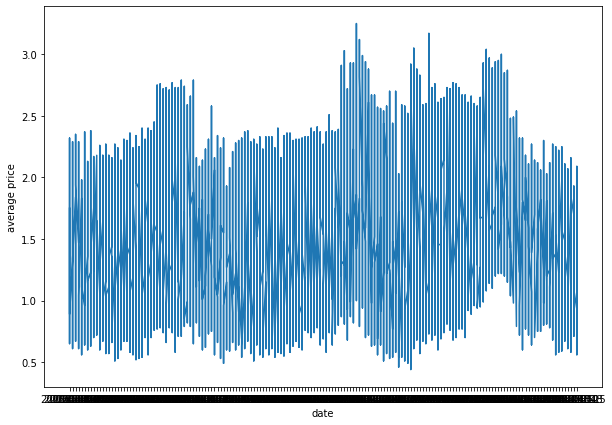

In [21]:
plt.figure(figsize=(10,7))
plt.plot(avocado_df['Date'], avocado_df['AveragePrice'])
plt.xlabel('date')

plt.ylabel('average price')
plt.show()

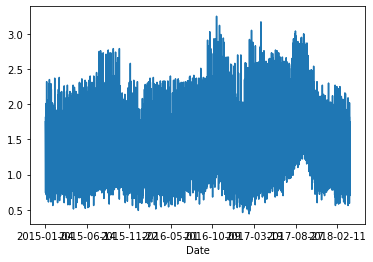

In [23]:
avocado_df.set_index('Date')['AveragePrice'].plot()
plt.show()

### 'region' 별로 데이터 몇개인지 시각화 하시오.

In [30]:
avocado_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 11569 to 8814
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.9+ MB


In [37]:
avocado_df['region'].unique()


array(['Southeast', 'Chicago', 'HarrisburgScranton', 'Pittsburgh',
       'Boise', 'WestTexNewMexico', 'LosAngeles', 'LasVegas', 'Atlanta',
       'DallasFtWorth', 'MiamiFtLauderdale', 'Plains', 'StLouis',
       'Syracuse', 'Midsouth', 'Sacramento', 'Boston', 'Charlotte',
       'Spokane', 'Albany', 'Houston', 'SouthCarolina', 'SanFrancisco',
       'TotalUS', 'RaleighGreensboro', 'BuffaloRochester',
       'NorthernNewEngland', 'GrandRapids', 'Denver', 'SanDiego',
       'BaltimoreWashington', 'Roanoke', 'RichmondNorfolk', 'Northeast',
       'SouthCentral', 'GreatLakes', 'Louisville', 'Seattle',
       'CincinnatiDayton', 'NewYork', 'NewOrleansMobile', 'Indianapolis',
       'Jacksonville', 'Columbus', 'Detroit', 'Philadelphia',
       'PhoenixTucson', 'Nashville', 'Portland', 'HartfordSpringfield',
       'Tampa', 'Orlando', 'West', 'California'], dtype=object)

In [36]:
avocado_df['region'].describe()

count               18249
unique                 54
top       RichmondNorfolk
freq                  338
Name: region, dtype: object

### 년도('year')별로 데이터가 몇건인지 확인하시오.

In [39]:
avocado_df.groupby('year').sum()


,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags
year,,,,,,,,,
2015,7723.94,4.385469e+09,1.709450e+09,1.761054e+09,1.427724e+08,7.721922e+08,6.346827e+08,1.320664e+08,5443128.28
2016,7517.80,4.820890e+09,1.525123e+09,1.672728e+09,1.598798e+08,1.463159e+09,1.106494e+09,3.366263e+08,20038284.84
2017,8669.56,4.934306e+09,1.652038e+09,1.544735e+09,9.121751e+07,1.646289e+09,1.222953e+09,3.993390e+08,23997172.34
2018,1746.40,1.382738e+09,4.604997e+08,4.077587e+08,2.293259e+07,4.915359e+08,3.607414e+08,1.235840e+08,7210591.87


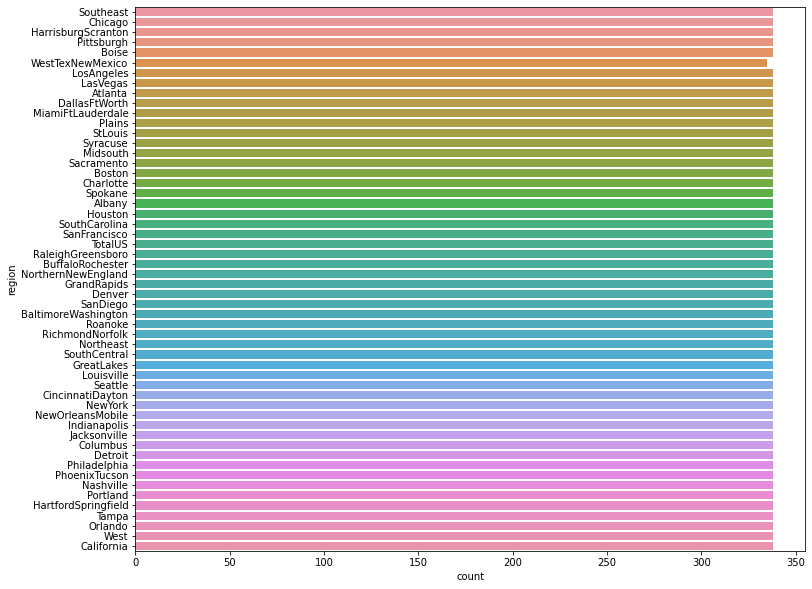

In [42]:
plt.figure(figsize=(12,10))
sns.countplot(data=avocado_df, y = 'region' )
plt.show()

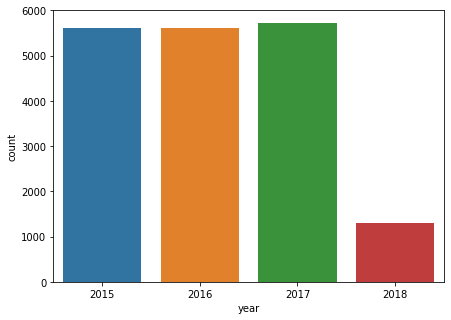

In [44]:
plt.figure(figsize=(7,5))
sns.countplot(data=avocado_df, x = 'year' )
plt.show()

### 프로펫 분석을 위해, 두개의 컬럼만 가져오시오. ('Date', 'AveragePrice')

In [45]:
avocado_df.head(2)

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
9593,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago


In [46]:
avocado_prophet_df = avocado_df.loc[:, ['Date',  'AveragePrice'] ]

In [47]:
avocado_prophet_df.head(3)

,Date,AveragePrice
11569,2015-01-04,1.75
9593,2015-01-04,1.49
10009,2015-01-04,1.68


# STEP 3: Prophet 을 이용한 예측 수행

### ds 와 y 로 컬럼명을 셋팅하시오.

Prophet 규칙
날짜가 들어가 있는 값은 데이터프레임 컬림명이 ds 
학습할 데이터는 y로 컬럼명을 바꾼다

In [49]:
avocado_prophet_df.columns = ['ds', 'y']
# 또는 rename()메소드 사용한다
# rename( columns= {딕셔너리 형태로 'key' : 'value'} )로 바꿔도 됨

In [50]:
avocado_prophet_df.head()

,ds,y
11569,2015-01-04,1.75
9593,2015-01-04,1.49
10009,2015-01-04,1.68
1819,2015-01-04,1.52
9333,2015-01-04,1.64


### 프로펫 예측 하시오.

Prophet()으로 객체 저장

In [51]:
m = Prophet()

In [52]:
# 365일치를 예측하시오.
m.fit(avocado_prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [56]:
# 미래의 예측치를 만들어준다 period= args는 날짜 수 를 입력해준다
#여기에서  freq='D' 파라미터는 디폴트 파라미터로 기본으로는 'D' 즉, 데이로 설정되어 있음
# 생략가능
# 참고- 파라마티 안내에서 위처럼 freq='D' 으로 나온다면 디폴트 파라미터라는 의미

future = m.make_future_dataframe(periods=365)
# 중요! future_datafreme으로 만들어서 future 변수로 저장해야한다
# 그렇게 만들어져 있음

In [57]:
# 예측한 것을 데이터프레임으로 만들어 준다
m.predict(future)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-04,1.498818,0.856752,1.854938,1.498818,1.498818,-0.113604,-0.113604,-0.113604,-0.113604,-0.113604,-0.113604,0.0,0.0,0.0,1.385214
1,2015-01-11,1.493637,0.894026,1.867130,1.493637,1.493637,-0.105192,-0.105192,-0.105192,-0.105192,-0.105192,-0.105192,0.0,0.0,0.0,1.388445
2,2015-01-18,1.488455,0.893002,1.842758,1.488455,1.488455,-0.104862,-0.104862,-0.104862,-0.104862,-0.104862,-0.104862,0.0,0.0,0.0,1.383592
3,2015-01-25,1.483273,0.898580,1.848232,1.483273,1.483273,-0.123788,-0.123788,-0.123788,-0.123788,-0.123788,-0.123788,0.0,0.0,0.0,1.359485
4,2015-02-01,1.478091,0.827750,1.814664,1.478091,1.478091,-0.152113,-0.152113,-0.152113,-0.152113,-0.152113,-0.152113,0.0,0.0,0.0,1.325978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,2019-03-21,1.161735,0.571933,1.600257,0.977010,1.343701,-0.086198,-0.086198,-0.086198,-0.086198,-0.086198,-0.086198,0.0,0.0,0.0,1.075537
530,2019-03-22,1.161003,0.504061,1.604598,0.975183,1.343657,-0.084518,-0.084518,-0.084518,-0.084518,-0.084518,-0.084518,0.0,0.0,0.0,1.076485
531,2019-03-23,1.160272,0.519081,1.580877,0.973355,1.343522,-0.082565,-0.082565,-0.082565,-0.082565,-0.082565,-0.082565,0.0,0.0,0.0,1.077707
532,2019-03-24,1.159540,0.553300,1.563573,0.971548,1.343086,-0.080358,-0.080358,-0.080358,-0.080358,-0.080358,-0.080358,0.0,0.0,0.0,1.079182


In [59]:
forecast = m.predict(future)

예측한 컬럼명은 yhat 임


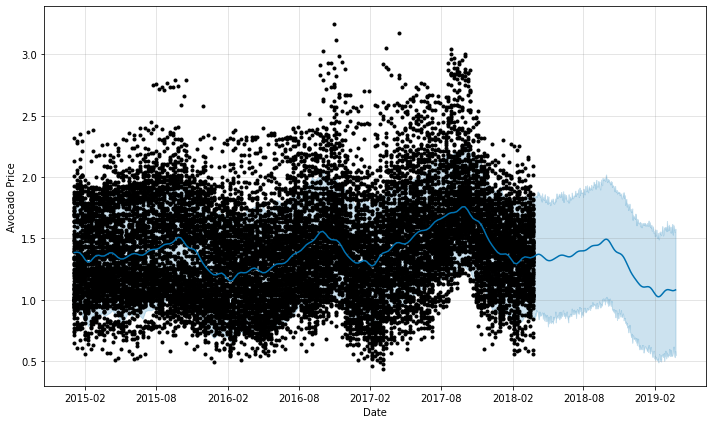

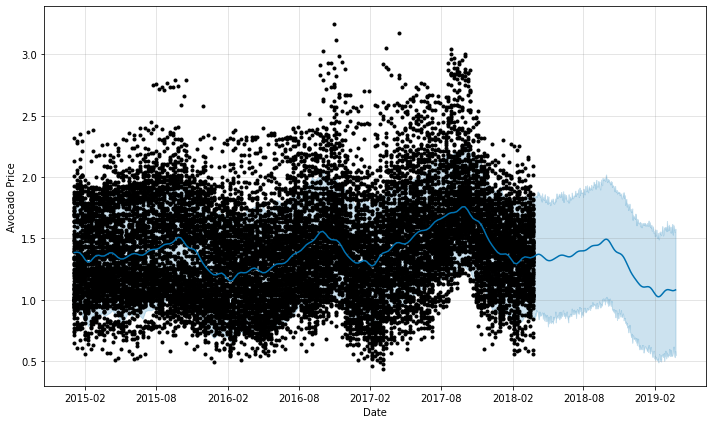

In [60]:
# 차트로 확인하시오.
m.plot(forecast, xlabel='Date', ylabel='Avocado Price')


In [ ]:
# 파랑색선이 yhat 값이고 , 검정색 점들은 데이터들


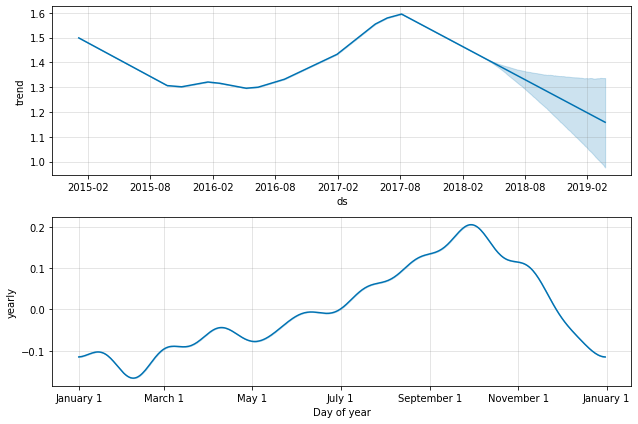

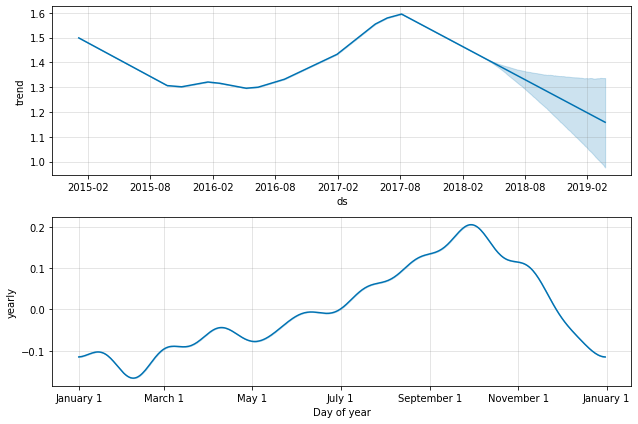

In [63]:
m.plot_components(forecast)

# tred, year로 예측을 해줌

# PART 2 : region 이 west 인 아보카도의 가격을 예측하시오.

In [ ]:
avocado_df_sample = 


In [64]:
avocado_df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
9593,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
10009,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
1819,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
9333,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


In [86]:
avocado_df.iloc[:, [0, 1, -1]]

,Date,AveragePrice,region
11569,2015-01-04,1.75,Southeast
9593,2015-01-04,1.49,Chicago
10009,2015-01-04,1.68,HarrisburgScranton
1819,2015-01-04,1.52,Pittsburgh
9333,2015-01-04,1.64,Boise
...,...,...,...
8574,2018-03-25,1.36,Chicago
9018,2018-03-25,0.70,SouthCentral
18141,2018-03-25,1.42,SouthCentral
17673,2018-03-25,1.70,California


In [87]:
avocado_region_df = avocado_df.iloc[:, [0, 1, -1]]

In [88]:
avocado_region_df = avocado_region_df.loc[ avocado_region_df['region'].str.lower() == 'west', ]

In [103]:
avocado_region_df

# 중요! ds, y는 정해진 법칙
# 여기서에서 추려진 컬럼중에서 
# Date컬럼은 ds로 바꾸고, AveragePrice 컬럼은 y로 바꿔준다
# 그리고 나머지 region컬럼은 나둬도 상관없다
# 하지만 메모리를 많이 차지할 수 있으므로 region은 drop시켜주는게 좋다

,ds,y,region
11881,2015-01-04,1.40,West
2755,2015-01-04,0.89,West
11880,2015-01-11,1.39,West
2754,2015-01-11,0.95,West
2753,2015-01-18,0.96,West
...,...,...,...
9104,2018-03-11,1.00,West
18226,2018-03-18,1.73,West
9103,2018-03-18,0.99,West
9102,2018-03-25,0.93,West


In [91]:
# 컬럼명 바꾸기
avocado_region_df.columns = ['ds', 'y', 'region']

In [92]:
avocado_region_df.head()

,ds,y,region
11881,2015-01-04,1.40,West
2755,2015-01-04,0.89,West
11880,2015-01-11,1.39,West
2754,2015-01-11,0.95,West
2753,2015-01-18,0.96,West


## 프로핏 객체 만들기

In [93]:
new_mm = Prophet()

## 학습 

In [94]:
new_mm.fit(avocado_region_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## future_dataframe으로 만들기

In [96]:
future = new_mm.make_future_dataframe(periods=365)

## predict으로 예측하기

In [98]:
forecast_west_region = new_mm.predict(future)

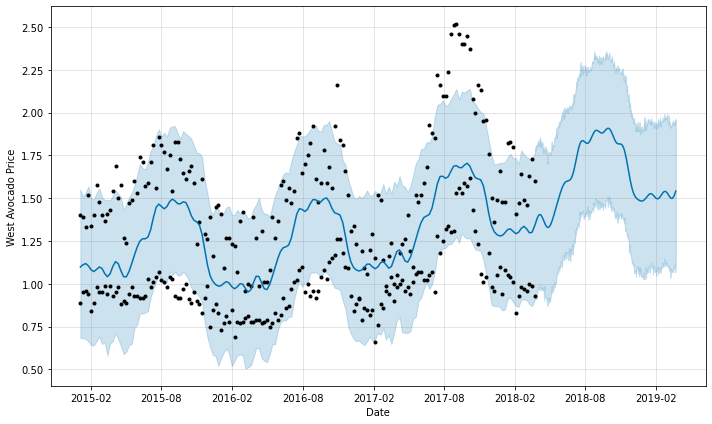

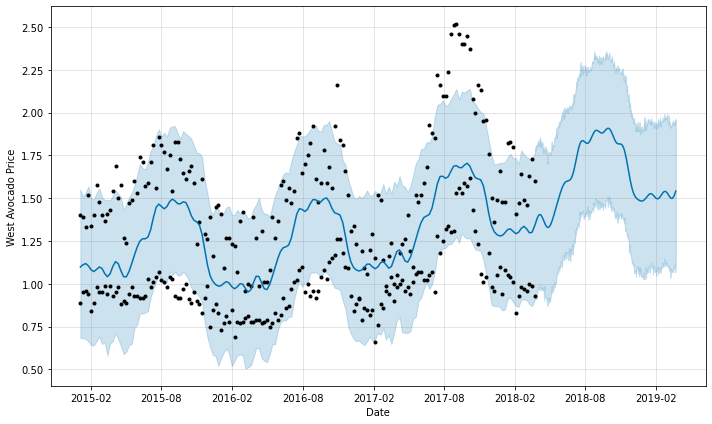

In [104]:
# 차트로 확인하시오.
new_mm.plot(forecast_west_region, xlabel='Date', ylabel='West Avocado Price')

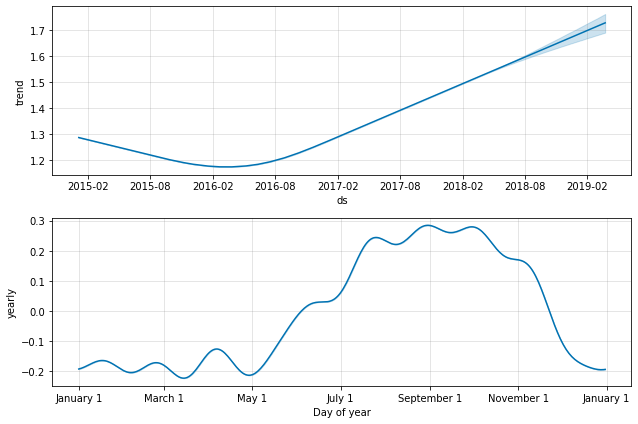

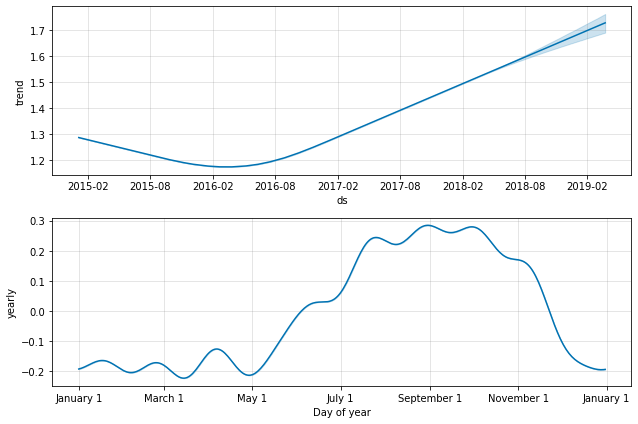

In [113]:
new_mm.plot_components(forecast_west_region)

# 결론 : 전체적인 아보카도 가격은 하락하지만,  웨스트 아보카도를 사면, 비싸게 팔수 있다. 

In [106]:
m = Prophet()

In [107]:
m.fit(avocado_region_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [109]:
# 주단위로 만들기
future = m.make_future_dataframe(periods=30, freq='W')

In [110]:
forecast = m.predict(future)

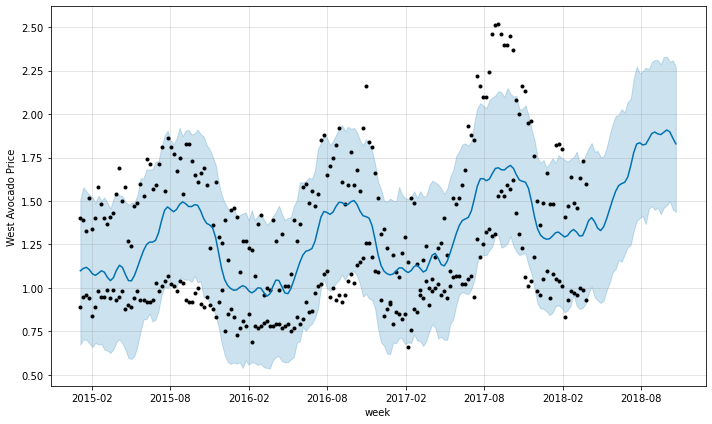

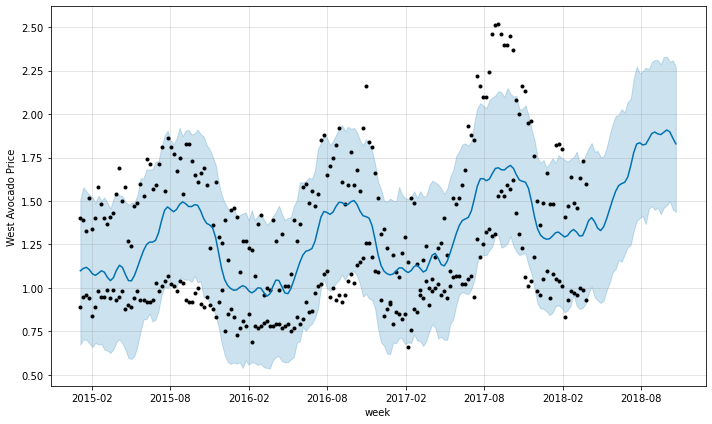

In [111]:
m.plot(forecast, xlabel='week', ylabel='West Avocado Price')

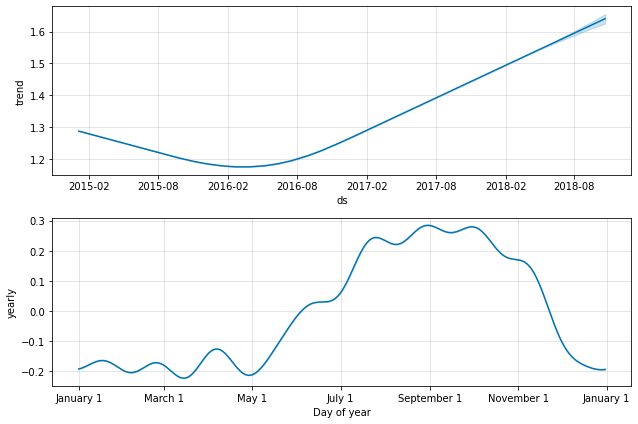

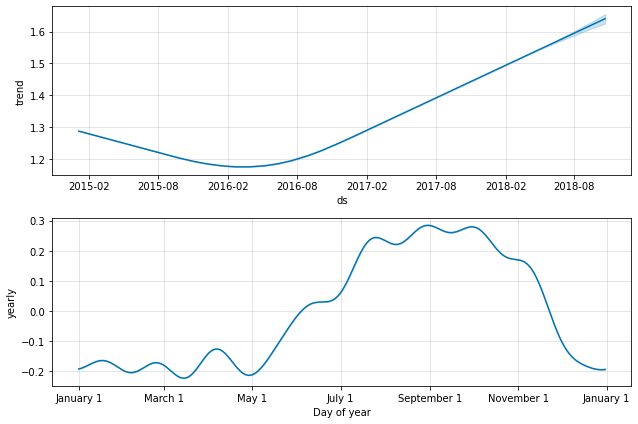

In [112]:
m.plot_components(forecast)